<a href="https://colab.research.google.com/github/nimamt/machine_learning/blob/master/pytorch/implementations/PyTorchLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

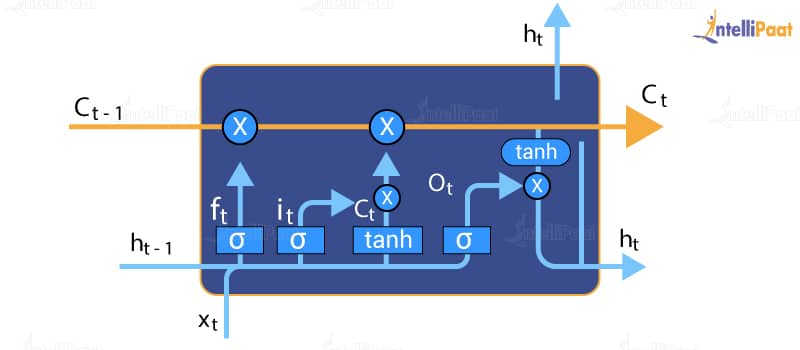

https://intellipaat.com/blog/what-is-lstm/

The central role of an LSTM model is held by a memory cell known as a **‘cell state’** that maintains its state over time. The cell state is the horizontal line that runs through the top of the below diagram. It can be visualized as a **conveyor belt** through which information just flows, unchanged.  

Information can be **added to or removed** from the cell state in LSTM and is **regulated by gates**. These gates optionally let the information flow in and out of the cell. It contains a **pointwise multiplication operation** and a sigmoid neural net layer that assist the mechanism.

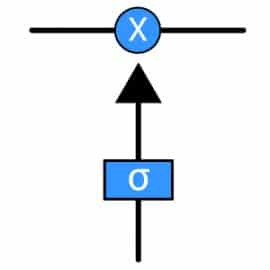

The sigmoid layer gives out numbers between zero and one, where zero means ‘nothing should be let through,’ and one means ‘everything should be let through.’

Recurrent neural networks seem to be doing a good job at remembering, theoretically. However, they have two downsides, **exploding gradient** and **vanishing gradient**, that make them redundant.

https://www.pluralsight.com/guides/introduction-to-lstm-units-in-rnn  
**A more detailed analysis.**

**Gate operations:** inputs are multiplied point-by-point

# Library Implementation

In [ ]:
import torch.nn as nn
import torch

rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
c0 = torch.randn(2, 3, 20)
output, (hn, cn) = rnn(input, (h0, c0))

# Detailed Implementation

https://stackoverflow.com/questions/50168224/does-a-clean-and-extendable-lstm-implementation-exists-in-pytorch

# Parameters

**Full list @:** https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM

* **Input dimension** - represents the size of the input at each time step, e.g. input of dimension 5 will look like this [1, 3, 8, 2, 3]  
* **Hidden dimension** - represents the size of the hidden state and cell state at each time step, e.g. the hidden state and cell state will both have the shape of [3, 5, 4] if the hidden dimension is 3  
* **Number of layers** - the number of LSTM layers stacked on top of each other


# Math Formula
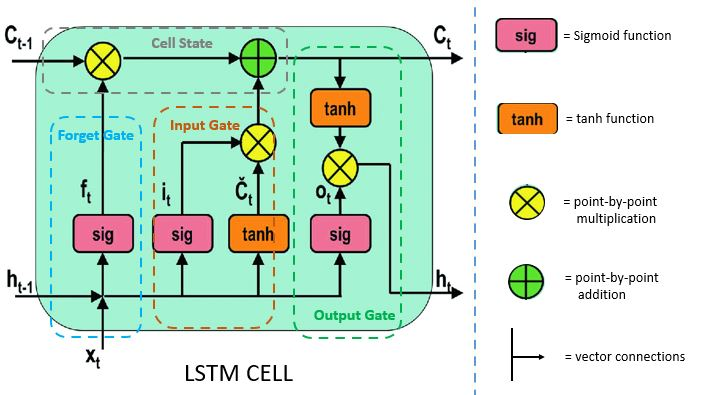

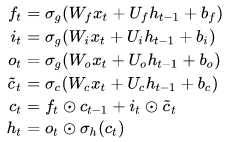

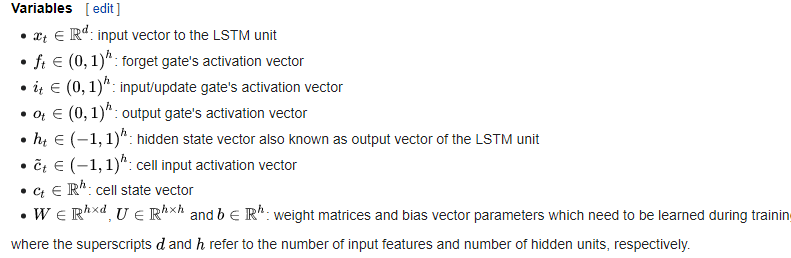

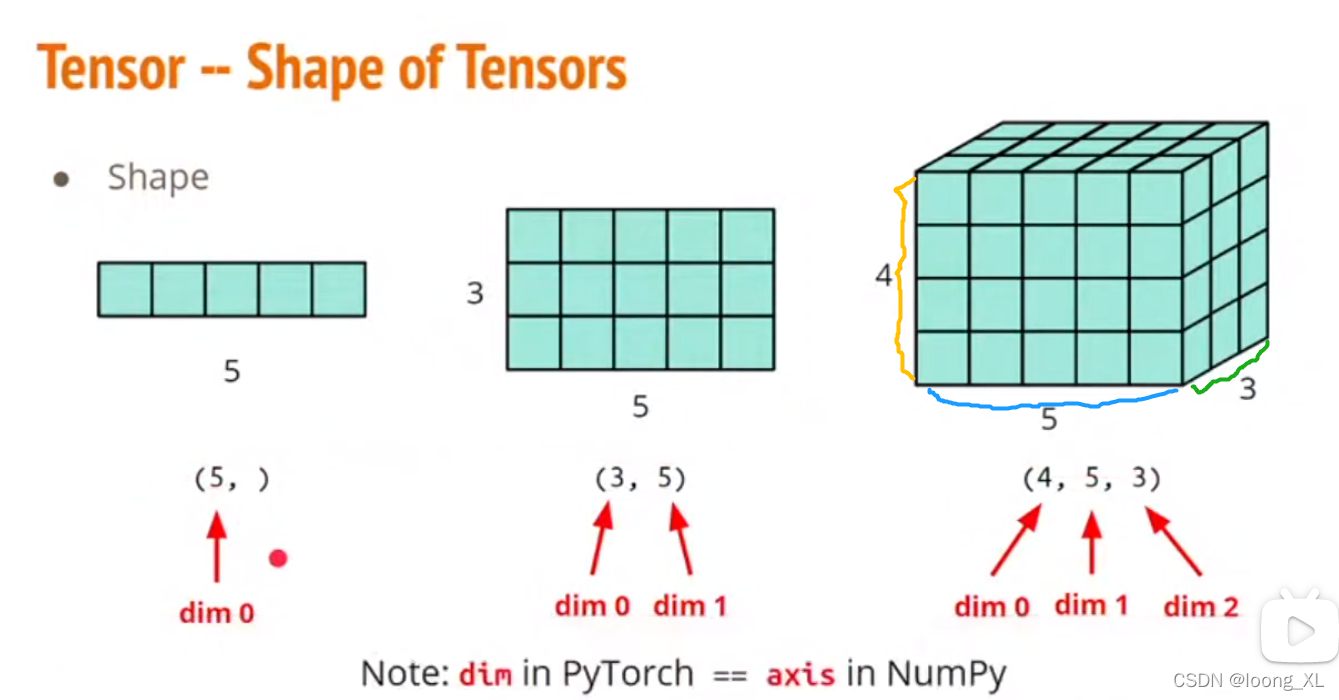

https://github.com/emadRad/lstm-gru-pytorch/blob/master/lstm_gru.ipynb

4*hidden_size because there are four gates.
Why is h the same as c in forward fun? They are both initially zero, but later on, this equality doesn't hold. 

In [ ]:
class LSTMCell(nn.Module):

    """
    An implementation of Hochreiter & Schmidhuber:
    'Long-Short Term Memory' cell.
    http://www.bioinf.jku.at/publications/older/2604.pdf

    """

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()



    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)
    
    def forward(self, x, hidden):
        
        hx, cx = hidden
        
        x = x.view(-1, x.size(1))
        
        gates = self.x2h(x) + self.h2h(hx)
    
        gates = gates.squeeze()
        
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)
        
        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)
        

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)        

        hy = torch.mul(outgate, F.tanh(cy))
        
        return (hy, cy)

# Better implementation

https://towardsdatascience.com/building-a-lstm-by-hand-on-pytorch-59c02a4ec091

**Important links**  
https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter  
https://pytorch.org/docs/stable/generated/torch.cat.html  
https://stackoverflow.com/questions/57237352/what-does-unsqueeze-do-in-pytorch  
https://stackoverflow.com/questions/48915810/what-does-contiguous-do-in-pytorch  
https://pytorch.org/docs/stable/generated/torch.Tensor.contiguous.html

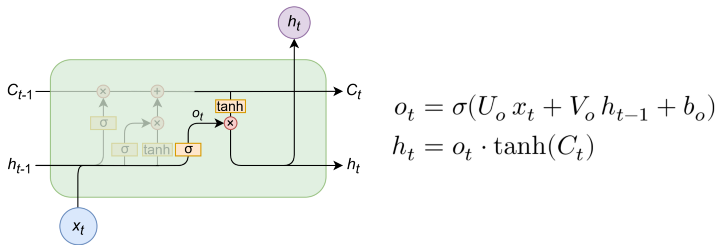

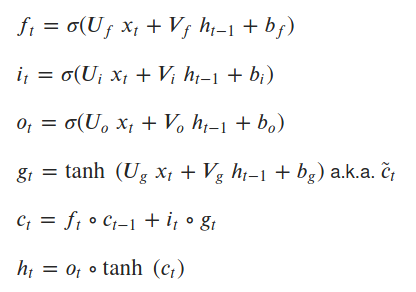

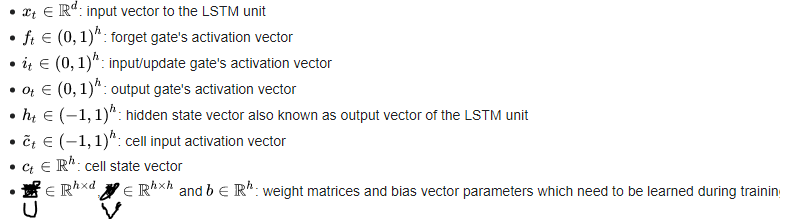

In [ ]:
import math
import torch
import torch.nn as nn

class NaiveCustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        
        #i_t
        self.U_i = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_i = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = nn.Parameter(torch.Tensor(hidden_sz))
        
        #f_t
        self.U_f = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_f = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = nn.Parameter(torch.Tensor(hidden_sz))
        
        #c_t
        self.U_c = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_c = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_c = nn.Parameter(torch.Tensor(hidden_sz))
        
        #o_t
        self.U_o = nn.Parameter(torch.Tensor(input_sz, hidden_sz))
        self.V_o = nn.Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = nn.Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()


    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self,
                x,
                init_states=None):
        
        """
        assumes x.shape represents (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size).to(x.device),
                torch.zeros(bs, self.hidden_size).to(x.device),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            
            i_t = torch.sigmoid(x_t @ self.U_i + h_t @ self.V_i + self.b_i)
            f_t = torch.sigmoid(x_t @ self.U_f + h_t @ self.V_f + self.b_f)
            g_t = torch.tanh(x_t @ self.U_c + h_t @ self.V_c + self.b_c)
            o_t = torch.sigmoid(x_t @ self.U_o + h_t @ self.V_o + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            
            hidden_seq.append(h_t.unsqueeze(0))
        
        #reshape hidden_seq p/ retornar
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)